## Introduction
This dataset from the University of Wisconsin contains various characteristics of a breast mass for each patient, identified with a unique id. The cells have been diagnosed as benign or malignant. My program performs Bayesian analysis to predict the diagnosis based on characteristics of the tumor, such as size and texture.

## Use of Bayesian Analysis
Bayes' Theorem for Classification Problems is stated as follows:

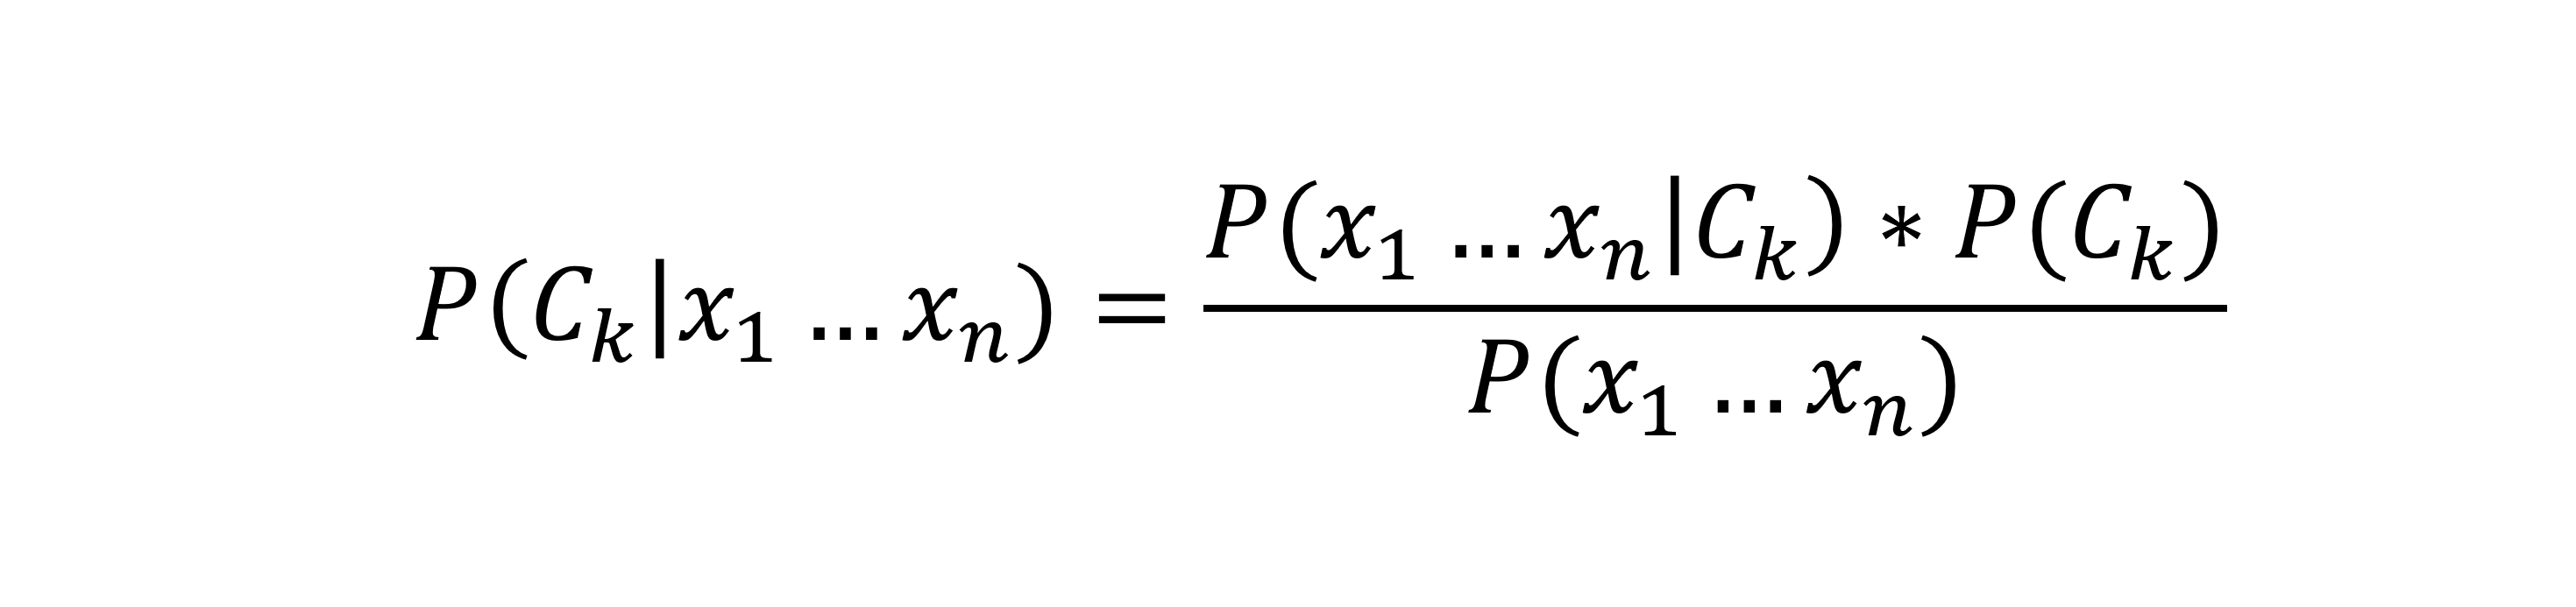

Where Ck is the the classification, benign or malignant, xn is a specific characteristic, and the denominator is the joint probability of factors 1 through n. 

The joint probability is not affected by the classification and therefore can be ignored to calculate the probability of a classification given the factors. 

The probability of a benign or malignant tumor is estimated using the training data.


## Setup

In [ ]:
# Load packages and dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
%matplotlib inline
sns.set_style('darkgrid')

In [ ]:
ds = pd.read_csv('../input/breast-cancer-wisconsin-data/data.csv')
ds

## Preprocessing

In [ ]:
def diagnosis(d):
    if d =='B'              :   return 0
    if d =='M'              :   return 1  
ds['diagnosis'] = ds['diagnosis'].apply(diagnosis)
ds

In [ ]:
# get rid of unnamed column, it is unnecessary
ds = ds.drop(['Unnamed: 32'], axis =1)
ds

In [ ]:
# Look for zero values
num_zeroes = (ds[["radius_mean", "texture_mean", "perimeter_mean", "area_mean", "smoothness_mean",
                 "compactness_mean", "concavity_mean", "concave points_mean", "symmetry_mean", "fractal_dimension_mean", 
                  "radius_se", "texture_se", "perimeter_se", "area_se", "smoothness_se", "compactness_se", "concavity_se", 
                  "concave points_se", "symmetry_se", "fractal_dimension_se", "radius_worst", "texture_worst", "perimeter_worst", 
                  "area_worst","smoothness_worst", "compactness_worst", "concavity_worst", "concave points_worst",
                 "symmetry_worst", "fractal_dimension_worst"]] == 0).sum()
print(num_zeroes)

By looking at the original dataset, I found that the zeros corresponded to thirteen patients whose tumors were all classified as benign. I decided to remove these thirteen patients from my analysis and assume it would not negatively affect my classification due to the large number of patients in the dataset.

In [ ]:
ds_clean = ds.copy()

In [ ]:
indexes = [101, 140, 174, 175, 192, 314, 391, 473, 538, 550, 557, 561, 568]
ds_clean = ds_clean.drop(indexes, axis = 0)
ds_clean

In [ ]:
# Next let's check the relationship between parameters offeatures
g = sns.PairGrid(data=ds_clean, vars=["radius_mean", "texture_mean", "smoothness_mean", "compactness_mean"], 
                 hue = 'diagnosis', height=3)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend();

In order to figure out more about the colinearity between variables, I am going to look at a correlation matrix. 

In [ ]:
# Correlation matrix
plt.figure(figsize=(16, 12))
sns.heatmap(ds_clean.drop('id', axis=1).corr(), cmap='YlGnBu', annot=True, fmt='.2f', vmin=0);
plt.title('Correlation between all features');

There is a lot of colinearity between the variables. In order to use the Naive Bayes assumption, the factors cannot be highly correlated to each other. Therefore, I will go through the variables and determine how many other variables they are correlated with by more than 0.6 or less than -0.6.

In [ ]:
variables = ["radius_mean", "texture_mean", "perimeter_mean", "area_mean", "smoothness_mean",
                 "compactness_mean", "concavity_mean", "concave points_mean", "symmetry_mean", "fractal_dimension_mean", 
                  "radius_se", "texture_se", "perimeter_se", "area_se", "smoothness_se", "compactness_se", "concavity_se", 
                  "concave points_se", "symmetry_se", "fractal_dimension_se", "radius_worst", "texture_worst", "perimeter_worst", 
                  "area_worst","smoothness_worst", "compactness_worst", "concavity_worst", "concave points_worst",
                 "symmetry_worst", "fractal_dimension_worst"]

for var in variables:
    correlations = ds_clean[ds_clean.columns[1:]].apply(lambda x: x.corr(ds_clean[var]))
    numCorr = 0
    
    for col in correlations.index:
        if (correlations[col] != 1 and (correlations[col]>0.6 or correlations[col]<-0.6)):
            numCorr+=1
            
    print (var, numCorr)

In [ ]:
#I am going to drop any columns with more than three correlations > 0.6
variables = ["radius_mean", "texture_mean", "perimeter_mean", "area_mean", "smoothness_mean",
                 "compactness_mean", "concavity_mean", "concave points_mean", "symmetry_mean", "fractal_dimension_mean", 
                  "radius_se", "texture_se", "perimeter_se", "area_se", "smoothness_se", "compactness_se", "concavity_se", 
                  "concave points_se", "symmetry_se", "fractal_dimension_se", "radius_worst", "texture_worst", "perimeter_worst", 
                  "area_worst","smoothness_worst", "compactness_worst", "concavity_worst", "concave points_worst",
                 "symmetry_worst", "fractal_dimension_worst"]

for var in variables:
    correlations = ds_clean[ds_clean.columns[1:]].apply(lambda x: x.corr(ds_clean[var]))
    numCorr = 0
    
    for col in correlations.index:
        if (correlations[col] != 1 and (correlations[col]>0.6 or correlations[col]<-0.6)):
            numCorr+=1
    if numCorr > 3:
        ds_clean = ds_clean.drop([var], axis = 1)
        
ds_clean


In [ ]:
# I will also go through and find the variables with minimal relation to diagnosis
corr_list = ds_clean[ds_clean.columns[1:]].apply(lambda x: x.corr(ds_clean['diagnosis']))
cols = []
for col in corr_list.index:
    if (corr_list[col]>0.2 or corr_list[col]<-0.2):
        cols.append(col)
        

cols

I now have a list of variables that are not highly correlated to each other and also have some correlation to the diagnosis. I will create a new correlation matrix to confirm that the data is ready to perform Bayesian analysis on.

In [ ]:
# Correlation matrix edited
variables = ["texture_mean", "smoothness_mean","symmetry_mean", "fractal_dimension_mean", 
                 "texture_se", "smoothness_se", "concavity_se", 
                  "concave points_se", "symmetry_se", "fractal_dimension_se", "texture_worst",  
                  "area_worst","smoothness_worst",  "concave points_worst",
                 "symmetry_worst", "fractal_dimension_worst"]
badCols = []
badCols.append('id')

for var in variables:
    if (var not in cols):
        badCols.append(var)
plt.figure(figsize=(16, 12))
sns.heatmap(ds_clean.drop(badCols, axis = 1).corr(), cmap='YlGnBu', annot=True, fmt='.2f', vmin=0);
plt.title('Correlation between features, edited');

In [ ]:
ds_clean = ds_clean[cols]
ds_clean.head()

There are still a few variables that have high correlations. I will go through and manually remove one from each of the pairs that has a correlation of 0.70 or greater.

In [ ]:
ds_clean = ds_clean.drop(['texture_mean', 'smoothness_mean', 'concavity_se', 
                          'symmetry_mean'], axis = 1)

Below are the distributions for the remaining variables. I am using Gaussian Naive Bayes for the analysis, which assumes a normal distribution for each of the predictors. Clearly, there are many factors which are not normally distributed and therefore may not work well with Gaussian Naive Bayes. Scikit learn, however, does not allow more than one distribution type be used for Bayes and therefore limits the capabilities of this algorithm.

In [ ]:
ds_clean.hist(alpha = 0.7, figsize=(12,10), bins=5);

## Training and Testing Data

In [ ]:
from sklearn.model_selection import train_test_split
Y = ds_clean['diagnosis']
X = ds_clean.drop(columns=['diagnosis'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 9)
print('X train shape: ', X_train.shape)
print('Y train shape: ', Y_train.shape)
print('X test shape: ', X_test.shape)
print('Y test shape: ', Y_test.shape)

## Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# fit the model
clf_nb = GaussianNB()
clf_nb.fit(X_train, Y_train)

pred_nb = clf_nb.predict(X_test)

# get the accuracy score
acc_nb = accuracy_score(pred_nb, Y_test)
print(acc_nb)

This prediction model accurately predicts a breast cancer diagnosis about 95.54% of the time.

## Confusion Matrix

In [ ]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = svm.SVC(kernel='linear', C=0.01).fit(X_train, Y_train)

np.set_printoptions(precision=2)

In [ ]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix", None)]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, Y_test,
                                 #display_labels=class_names,
                                 cmap=plt.cm.Reds,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

The confusion matrix shows that if the model predicts the tumor is benign, the probability is approximately 93.4% that the diagnosis is correct, and therefore there is a 6.6% chance that the tumor is actually malignant when the software predicted it was benign. Similarly, if the program predicts a malignant diagnosis, there is approximately a 91.67% chance that the tumor was correctly identified and an 8.33% chance the tumor is actually benign. 

There is a significant risk with using this model to generate predictions because of the severe consequences that could arise if a patient is given an incorrect diagnosis. If they are incorrectly told their tumor is benign, then they will not recieve the proper treatement for the cancer. Similarly, if the tumor is incorrectly predicted as malignant, there could be undue stress put upon the patient which would otherwise be avoided with a more accurate model. 

